Modelling with RFE n = 20

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict
import joblib
import glob

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif, RFECV
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, ConfusionMatrixDisplay, classification_report, auc, roc_curve
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,28102,172.16.0.5-192.168.50.1-553-11930-17,172.16.0.5,553,192.168.50.1,11930,17,2018-12-01 11:23:04.133911,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
1,17675,172.16.0.5-192.168.50.1-997-4051-17,172.16.0.5,997,192.168.50.1,4051,17,2018-12-01 11:32:18.205323,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
2,661545,172.16.0.5-192.168.50.1-27238-3411-6,172.16.0.5,27238,192.168.50.1,3411,6,2018-12-01 13:31:10.155752,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
3,688385,172.16.0.5-192.168.50.1-36181-39435-6,172.16.0.5,36181,192.168.50.1,39435,6,2018-12-01 13:30:48.279274,51,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
4,16016,172.16.0.5-192.168.50.1-35261-14404-17,172.16.0.5,35261,192.168.50.1,14404,17,2018-12-01 13:02:49.155721,105961,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [6]:
df.describe()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,360000.000000,360000.000000,3.600000e+05,3.600000e+05,360000.000000,...,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000
mean,91493.758128,26078.477756,30912.601833,14.700269,2.200160e+06,8.975250,0.585044,3.733058e+03,3.847677e+02,582.758328,...,-3.609785e+07,7.325171e+03,2.620700e+03,1.084865e+04,5.733338e+03,6.801519e+05,1.105356e+05,8.047233e+05,5.820746e+05,0.930525
std,135889.709116,25364.107740,20110.524442,4.502866,1.275317e+07,250.280517,12.328315,3.287519e+04,3.131816e+04,544.547707,...,1.925211e+08,1.685573e+05,7.402011e+04,2.224704e+05,1.570655e+05,4.457633e+06,1.025535e+06,5.103451e+06,4.112389e+06,0.254261
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,11986.000000,771.000000,13028.000000,17.000000,1.000000e+00,2.000000,0.000000,4.580000e+02,0.000000e+00,229.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,38063.500000,21346.500000,30909.000000,17.000000,2.000000e+00,2.000000,0.000000,1.088000e+03,0.000000e+00,415.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,106306.000000,52107.250000,48665.000000,17.000000,1.821250e+03,4.000000,0.000000,2.944000e+03,0.000000e+00,1035.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,805151.000000,65534.000000,65535.000000,17.000000,1.200000e+08,86220.000000,4602.000000,1.526642e+07,8.818824e+06,32120.000000,...,1.480000e+03,1.721058e+07,2.284064e+07,4.358468e+07,1.310114e+07,1.058368e+08,6.600292e+07,1.058368e+08,1.058368e+08,1.000000


In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

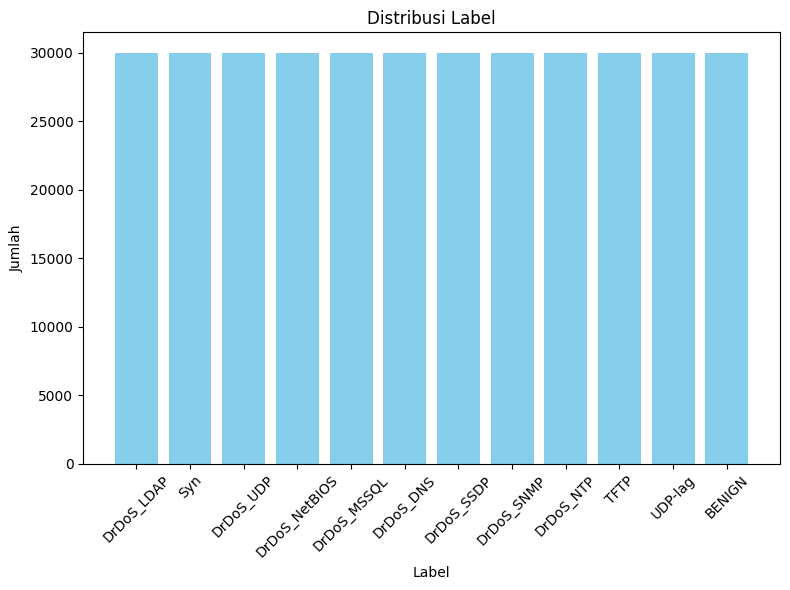

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

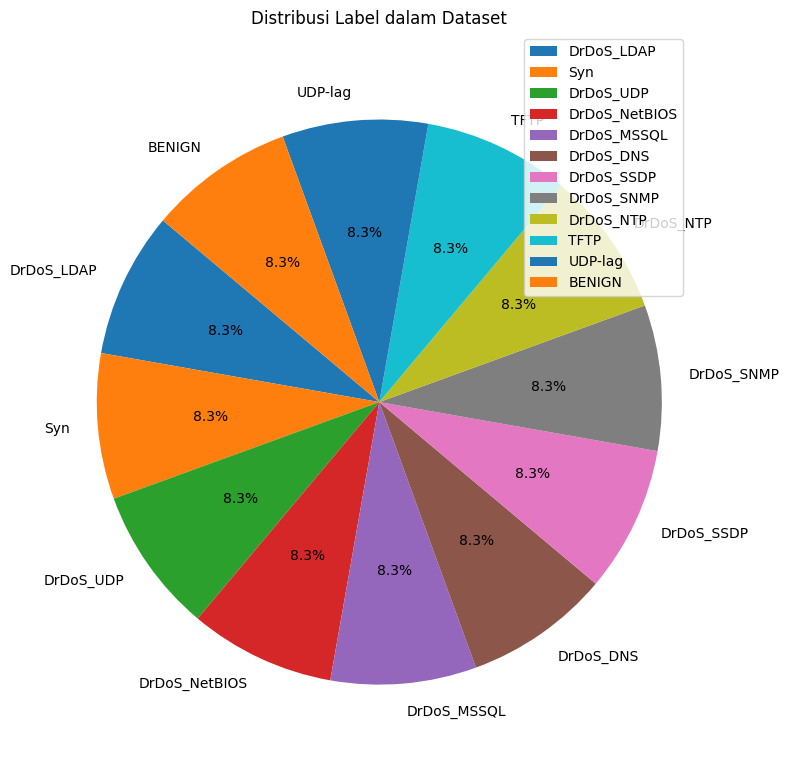

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

,Label
0,2
1,2
2,9
3,9
4,8


### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Selection RFE

#### StandarScaler

In [16]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [17]:
# Copy data asli untuk jaga-jaga
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [18]:
# Standarisasi fitur numerik saja
scaler = StandardScaler()

# Standarisasi hanya fitur numerik, simpan hasil ke variabel baru
X_train_scaled = X_train_copy.copy()
X_test_scaled = X_test_copy.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_copy[numerical_features])

In [19]:
# Opsional: Kalau mau konversi ke array, tinggal pakai
X_train_scaled_array = X_train_scaled.to_numpy()
X_test_scaled_array = X_test_scaled.to_numpy()

In [20]:
X_train.shape

(252000, 79)

#### RFECV

In [31]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42), step=1, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 fe

RFECV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
      scoring='accuracy', verbose=1)

In [32]:
ranking = rfecv.ranking_
sorted_idx = np.argsort(ranking)

In [37]:
jumlah_fitur = range(10,70,5)
akurasi = []

for n in jumlah_fitur:
    selected_idx = sorted_idx[:n]
    X_selected = X_train_scaled.iloc[:, selected_idx]  # atau df.iloc[:, selected_idx]
    
    score = cross_val_score(RandomForestClassifier(), X_selected, y_train, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    mean_score = score.mean()
    akurasi.append(mean_score)

    print(f"{n} fitur → Akurasi: {mean_score:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


10 fitur → Akurasi: 0.7500


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


15 fitur → Akurasi: 0.7500


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


20 fitur → Akurasi: 0.7606


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.1s finished


25 fitur → Akurasi: 0.7603


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


30 fitur → Akurasi: 0.7602


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


35 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


40 fitur → Akurasi: 0.7600


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


45 fitur → Akurasi: 0.7598


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


50 fitur → Akurasi: 0.7596


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


55 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


60 fitur → Akurasi: 0.7597
65 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.7s finished


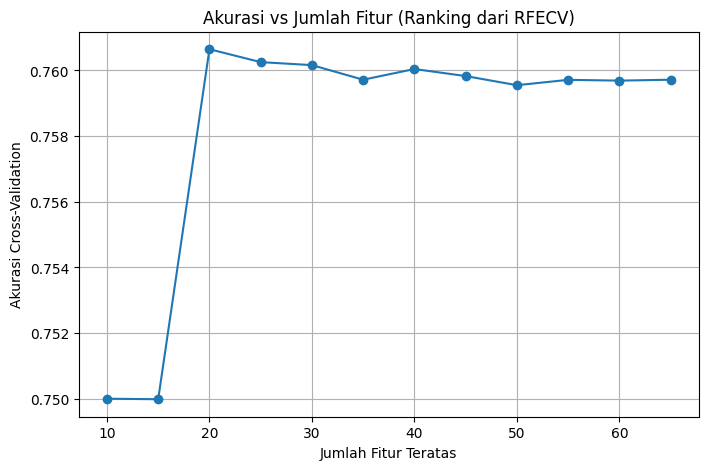

In [38]:
plt.figure(figsize=(8,5))
plt.plot(jumlah_fitur, akurasi, marker='o')
plt.xlabel('Jumlah Fitur Teratas')
plt.ylabel('Akurasi Cross-Validation')
plt.title('Akurasi vs Jumlah Fitur (Ranking dari RFECV)')
plt.grid(True)
plt.show()

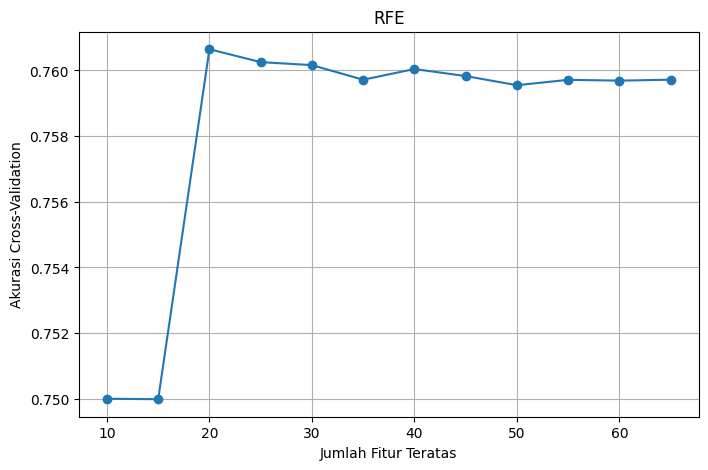

In [39]:
plt.figure(figsize=(8,5))
plt.plot(jumlah_fitur, akurasi, marker='o')
plt.xlabel('Jumlah Fitur Teratas')
plt.ylabel('Akurasi Cross-Validation')
plt.title('RFE')
plt.grid(True)
plt.show()

#### RFE + Random Forest

In [ ]:
# Range jumlah fitur yang diuji
model_rfe = RandomForestClassifier(random_state=42)
k_values = range(10,70,5)
scores_rfe = []

for k in k_values:
    # Buat pipeline RFE + model
    pipeline = Pipeline([
        ('rfe', RFE(estimator= model_rfe, n_features_to_select=k)),
        ('clf', model_rfe)
    ])
    
    # Validasi silang aman (RFE fit hanya di data train tiap fold)
    results = cross_validate(pipeline, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True, verbose=3)

    mean_test_score = results['test_score'].mean()
    scores_rfe.append(mean_test_score)

# Plot hasil
plt.plot(k_values, scores_rfe, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Mean CV Accuracy")
plt.title("RFE Feature Selection Performance (via Pipeline)")
plt.grid(True)
plt.show()

#### Selected Features with RFE

In [21]:
# Mendefinisikan model machine learning (Random Forest)
model = RandomForestClassifier()

# Menentukan jumlah fitur yang ingin dipertahankan
num_features_to_retain = 20

# Menginisialisasi selektor RFE dengan model dan jumlah fitur yang ingin dipertahankan
rfe = RFE(estimator=model, n_features_to_select=num_features_to_retain)

# Melatih selektor RFE dengan dataset
rfe.fit(X_train_scaled, y_train)

# Mendapatkan fitur-fitur yang telah terseleksi
selected_features = np.where(rfe.support_)[0]

# Menampilkan indeks fitur terpilih
print("Selected feature indices:", selected_features)

Selected feature indices: [ 0  2  5  7  8  9 15 19 21 22 24 35 39 40 41 48 53 54 63 78]


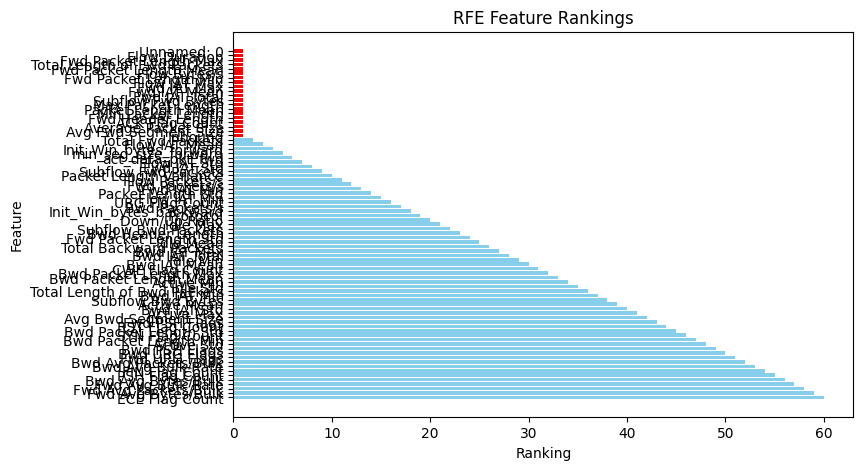

In [22]:
rankings = rfe.ranking_
feature_names = X_train_scaled.columns

# Membuat dataframe untuk visualisasi ranking fitur yang dibuat RFE
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': rankings
}).sort_values(by='Ranking', ascending=True)

# Menampilkan plot visualisasi ranking fitur
plt.figure(figsize=(8, 5))
plt.barh(ranking_df['Feature'], ranking_df['Ranking'], color='skyblue')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.title('RFE Feature Rankings')
plt.gca().invert_yaxis()  # Invert y-axis untuk pembacaan yang lebih baik
colors = ['red' if rank == 1 else 'skyblue' for rank in ranking_df['Ranking']]
plt.barh(ranking_df['Feature'], ranking_df['Ranking'], color=colors)
plt.show()

In [21]:
selected_features = [ 0, 2, 5, 7, 8, 9, 15, 19, 21, 22, 24, 35, 39, 40, 41, 48, 53, 54, 63, 78]

In [22]:
# Menyimpan data yang telah terseleksi
X_train_selected_scaled = X_train_scaled.iloc[:, selected_features].to_numpy()
X_test_selected_scaled = X_test_scaled.iloc[:, selected_features].to_numpy()

In [32]:
list = X_train_scaled.columns[selected_features]
print(list)

Index(['Unnamed: 0', 'Flow Duration', 'Total Length of Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd Header Length',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'ACK Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size',
       'Subflow Fwd Bytes', 'Inbound'],
      dtype='object')


In [30]:
X_test_scaled_array

array([[-0.24282183, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [ 0.24146577, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.63685356,  6.        ,  8.90699269, ...,  1.81049224,
         2.28596109,  0.        ],
       ...,
       [-0.45591514, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.25304725, 17.        , -0.15506345, ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.39273824, 17.        , -0.16336023, ..., -0.15651604,
        -0.14024739,  1.        ]])

In [28]:
X_test_selected_scaled

array([[-0.24282183, -0.1717637 , -0.07773201, ..., -0.34919236,
        -0.07773201,  1.        ],
       [ 0.24146577, -0.1717637 , -0.07773201, ..., -0.34919236,
        -0.07773201,  1.        ],
       [-0.63685356,  8.90699269, -0.07436492, ..., -1.0070599 ,
        -0.07436492,  0.        ],
       ...,
       [-0.45591514, -0.1717637 , -0.02132031, ...,  1.67403352,
        -0.02132031,  1.        ],
       [-0.25304725, -0.15506345, -0.0434913 , ..., -0.41421799,
        -0.0434913 ,  1.        ],
       [-0.39273824, -0.16336023, -0.06136278, ..., -0.41143117,
        -0.06136278,  1.        ]])

### Modeling with Feature Selection

In [23]:
def evaluate_model_2(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1-score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

In [25]:
models = {
    "KNN": KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'),
    "Naive Bayes": GaussianNB(var_smoothing=np.float64(0.01)),
    "Logistic Regression": LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "XGBoost": xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42),
    "AdaBoost": AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)
}

### ROC

In [38]:
# Binarisasi label multiclass
classes = np.unique(y)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

In [27]:
# Binarisasi untuk evaluasi saja
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [36]:
# Buat base SVC tanpa probability
base_svc = SVC(kernel='rbf', C=1, gamma='scale', probability=False, random_state=42)

# Kalibrasi output menjadi probabilitas
calibrated_svc = CalibratedClassifierCV(base_svc, method='sigmoid', cv=3)

# Bungkus ke dalam OvR
model = OneVsRestClassifier(calibrated_svc, n_jobs=-1)

# Training model
model.fit(X_train_selected_scaled, y_train)

# Save model
joblib.dump(model, f'model_roc_rfe/model_SVM_calibrated.joblib')
print("Model SVM (dengan kalibrasi) berhasil disimpan")

# Prediksi probabilitas untuk ROC AUC multiclass
y_score = model.predict_proba(X_test_selected_scaled)

# Save hasil prediksi
np.save(f'model_roc_rfe/y_score_svm_calibrated.npy', y_score)

# Hitung ROC AUC multiclass OvR
roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f'ROC AUC SVM (calibrated OvR): {roc_auc:.4f}')

Model SVM (dengan kalibrasi) berhasil disimpan
ROC AUC SVM (calibrated OvR): 0.9523


In [ ]:
model = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True))

model.fit(X_train_selected_scaled, y_train)  # tetap pakai label asli

joblib.dump(model, f'model_roc_rfe/model_SVM.joblib')
print("model berhasil disave")

y_score = model.predict_proba(X_test_selected_scaled)

# Save model dan score
np.save(f'model_roc_rfe/y_score_svm.npy', y_score)

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f'ROC AUC SVM: {roc_auc:.4f}')

In [56]:
# Cari semua file .npy di folder saat ini
joblib_files = glob.glob('model_roc_rfe/*.joblib')
joblib_files

['model_roc_rfe\\stacking_1_false.joblib',
 'model_roc_rfe\\stacking_1_true.joblib',
 'model_roc_rfe\\stacking_2_false.joblib',
 'model_roc_rfe\\stacking_2_true.joblib',
 'model_roc_rfe\\stacking_3_false.joblib',
 'model_roc_rfe\\stacking_3_true.joblib',
 'model_roc_rfe\\stacking_4_false.joblib',
 'model_roc_rfe\\stacking_4_true.joblib']

In [ ]:
# Training model
for file_name in joblib_files:
    # Ambil nama model dari nama file
    model_name = file_name.replace('model_roc_rfe\\', '') \
                          .replace('model_roc_rfe/', '') \
                          .replace('.joblib', '') \
                          .replace('_', ' ')

    print(f"\n🔍 Memproses model: {model_name}")

    # model.fit(X_train_selected_scaled, y_train)  # tetap pakai label asli
    model = joblib.load(file_name)

    y_score = model.predict_proba(X_test_selected_scaled)

    # Save model dan score
    np.save(f'model_roc_rfe/y_score_{model_name}.npy', y_score)

    # Hitung ROC AUC
    roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    print(f'ROC AUC {model_name}: {roc_auc:.4f}')


🔍 Memproses model: stacking 1 false


In [37]:
# Cari semua file .npy di folder saat ini
npy_files = glob.glob('model_roc_rfe/*.npy')
print(npy_files)  # Untuk cek nama filenya

['model_roc_rfe\\y_score_AB.npy', 'model_roc_rfe\\y_score_DT.npy', 'model_roc_rfe\\y_score_KNN.npy', 'model_roc_rfe\\y_score_LR.npy', 'model_roc_rfe\\y_score_NB.npy', 'model_roc_rfe\\y_score_RF.npy', 'model_roc_rfe\\y_score_stacking proposed false.npy', 'model_roc_rfe\\y_score_stacking proposed true.npy', 'model_roc_rfe\\y_score_SVM.npy', 'model_roc_rfe\\y_score_XGB.npy']


Processing: model AB
Processing: model DT
Processing: model KNN
Processing: model LR
Processing: model NB
Processing: model RF
Processing: model XGB
Processing: stacking proposed false
Processing: stacking proposed true
Processing: svm calibrated


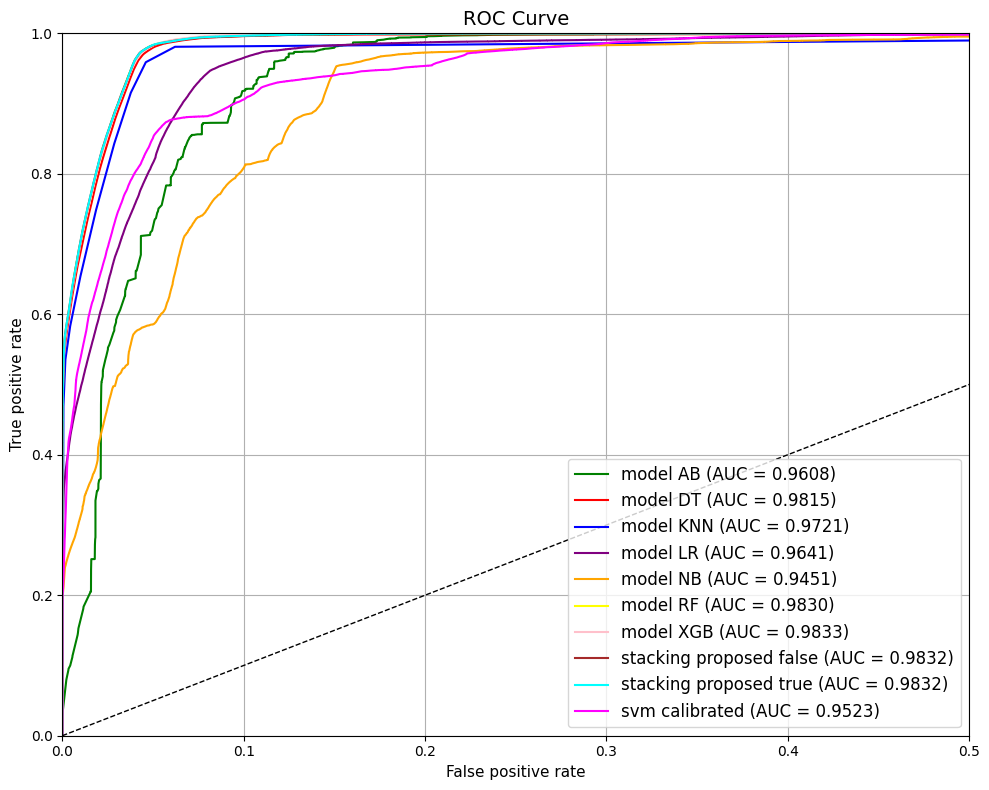

In [25]:
# List warna untuk tiap model ----Tidak Digunakan -----
colors = [
    'green', 'red', 'blue', 'purple', 'orange', 'yellow', 'pink',
    'brown', 'cyan', 'magenta', 'lime', 'gray', 'olive', 'teal', 'navy',
    'gold', 'coral', 'darkgreen', 'maroon'
]

plt.figure(figsize=(10, 8))

# Loop setiap file dan warna
for file_name, color in zip(npy_files, colors):
    
    # Ambil nama model dari nama file, buang ekstensi
    model_name = file_name.replace('model_roc_rfe\\y_score_', '') \
                    .replace('model_roc_rfe/y_score_', '') \
                    .replace('.npy', '') \
                    .replace('_', ' ')
    
    print(f"Processing: {model_name}")
    
    # Load hasil prediksi
    y_score = np.load(file_name)
    
    # Hitung ROC macro-average
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    auc_score = roc_auc_score(y_test_bin, y_score, average='macro')

    # Plot ROC Curve
    plt.plot(fpr, tpr, lw=1.5, markersize=2, color=color, label=f"{model_name} (AUC = {auc_score:.4f})")

# Garis diagonal baseline
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Zoom area kritis FPR kecil
plt.xlim([0.0, 0.5])   # Fokus FPR 0 - 0.2
plt.ylim([0.0, 1.0])   # Fokus TPR 0.8 - 1.0

plt.xlabel('False positive rate', fontsize=11)
plt.ylabel('True positive rate', fontsize=11)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Processing: AB
Processing: DT
Processing: KNN
Processing: LR
Processing: NB
Processing: RF
Processing: stacking proposed false
Processing: stacking proposed true
Processing: SVM
Processing: XGB


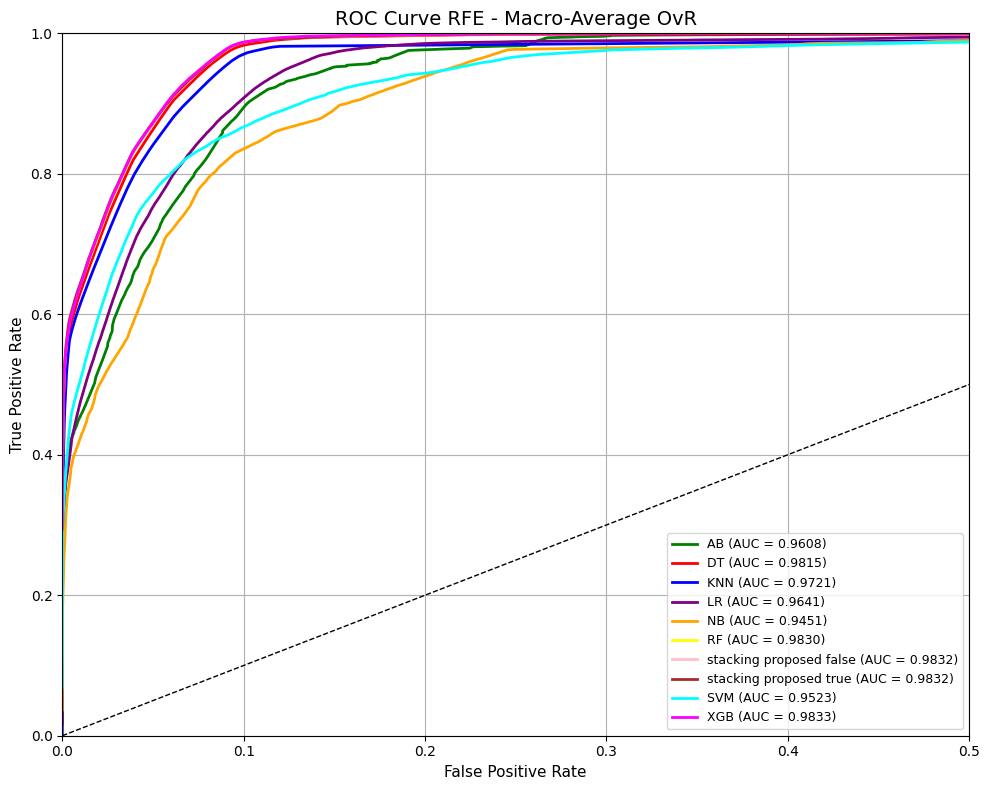

In [39]:
colors = [
    'green', 'red', 'blue', 'purple', 'orange', 'yellow', 'pink',
    'brown', 'cyan', 'magenta', 'lime', 'gray', 'olive', 'teal', 'navy',
    'gold', 'coral', 'darkgreen', 'maroon', 'lightblue', 'chocolate', 'darkcyan', 'crimson'
]

plt.figure(figsize=(10, 8))

for file_name, color in zip(npy_files, colors):
    model_name = file_name.replace('model_roc_rfe\\y_score_', '') \
                          .replace('model_roc_rfe/y_score_', '') \
                          .replace('.npy', '') \
                          .replace('_', ' ')
    
    print(f"Processing: {model_name}")
    y_score = np.load(file_name)

    # Hitung ROC dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Hitung average macro ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    auc_macro = auc(all_fpr, mean_tpr)

    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr, color=color,
             label=f"{model_name} (AUC = {auc_macro:.4f})", lw=2)

# Baseline diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Fokus area
plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve RFE - Macro-Average OvR', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()